In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib
from pathlib import Path
import logging

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

# DATA_DIR = Path.cwd() / "data"
# MODEL_DIR = DATA_DIR / "models"
# MODEL_DIR.mkdir(parents=True, exist_ok=True)

# 데이터 로드
df = pd.read_csv(r"C:\Users\HoYeon\Desktop\ML_ex\data\ticketing_data.csv")
X = df.drop('is_bot', axis=1)
y = df['is_bot']

# 클래스 최소 2개 검증
if y.value_counts().min() < 2:
    raise ValueError("각 클래스에 최소 2개 샘플 필요 -> 데이터 재생성")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=300, random_state=42, n_jobs=-1, eval_metric="logloss")
}

results = {}
best_model = None
best_auc = 0

for name, model in models.items():
    print(f"\n[학습중] {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {
        "auc": auc,
        "report": classification_report(y_test, y_pred, output_dict=True)
    }
    print(f"   -> AUC: {auc:.5f}")
    if auc > best_auc:
        best_auc = auc
        best_model = model

# 최고 성능 모델 저장 
best_path = "best_model.pkl"
joblib.dump(best_model, best_path)
print(f"\n최고 모델 저장")
print(f"최고 AUC: {best_auc:.5f} -> {type(best_model).__name__}")


[학습중] LogisticRegression...


c:\Users\HoYeon\miniconda3\envs\hoyeon\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   -> AUC: 0.96404

[학습중] RandomForest...
   -> AUC: 0.96774

[학습중] XGBoost...
   -> AUC: 0.96211

최고 모델 저장
최고 AUC: 0.96774 -> RandomForestClassifier


AUC: 0.99752
Precision (bot): 1.000
Recall    (bot): 0.985
F1        (bot): 0.993


Text(0.5, 1.0, 'Confusion Matrix')

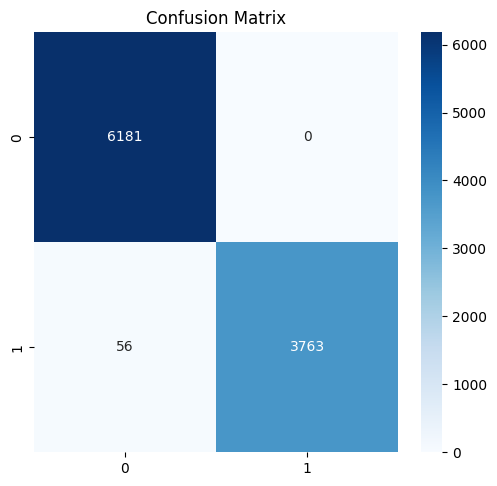

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import joblib
from pathlib import Path

# DATA_DIR = "data"
# MODEL_DIR = "models"

df = pd.read_csv(r"C:\Users\HoYeon\Desktop\ML_ex\data\ticketing_data.csv")
X = df.drop("is_bot", axis=1)
y = df["is_bot"]

model_path = (Path.cwd() / "best_model.pkl")
model = joblib.load(model_path)

y_prob = model.predict_proba(X)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

auc = roc_auc_score(y, y_prob)
report = classification_report(y, y_pred, output_dict=True)

print(f"AUC: {auc:.5f}")
print(f"Precision (bot): {report['1']['precision']:.3f}")
print(f"Recall    (bot): {report['1']['recall']:.3f}")
print(f"F1        (bot): {report['1']['f1-score']:.3f}")

plt.figure(figsize=(20, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')